# 5.0 Predicting client churn - Modeling

## 5.1 Introduction

Customers Churn

The Telco company specializes in providing telephone and internet service to California. Thanks to its promotions, the company reached the number of 7,073 customers during the third quarter. However, it encounters serious difficulties in retaining its customers. In fact, the disengagement rate during this quarter was around 26.54%. 
This difficulty in retaining customers is reflected in the structure of the company's customer base: 
  • 25% of customers have less than 9 months of relationship 
  • The median duration of the customer relationship with the company is 29 months, far from the 72 months relationship of the most loyal customers 
  • 75% of customers have a relationship duration of less than 55 months. 

Telco Management would like to commit to a loyalty policy by reducing the disengagement rate to less than 10% by: 
  • Identification, upon entering a relationship, of the customers most likely to leave the company after the promotion period. 
  • Concrete actions are likely to build loyalty among current customers. 

The Data Science team was entrusted with the mission of identifying the factors on which to act to retain existing customers and to develop a model to identify potential customers towards whom future promotions should be directed. This work involves the participation of: 
  • General management for orientations 
  • Director of the Customer Service team 
  • Director of the Marketing team 
  • Director of Technology 

It was produced using information available in the customer database which contains 33 variables for each customer. The approach adopted is: 
 • Retain the 'Churn Label' column as an explanatory or independent variable 
 • Determine to what extent each of the other variables allows predicting the explanatory variable 
 • Retain the most relevant variables to develop a model based on the regression mode with the smallest absolute error

This document is the continuation of Feature engineering. It contains:
 - analysis of three models and their performance
 - choice of the model to identify customers likely to churn
   

## 5.2 Import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint

In [2]:
# Import Machine Learning models:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler


## 5.3 Import the data

In [3]:
# Code task 1#
# Import the data
df = pd.read_csv("df_churn_model_f")
df.head().T

,0,1,2,3,4
Senior Citizen,0,0,0,0,0
Partner,0,0,0,0,0
Dependents,0,0,0,1,1
Tenure Months,2,2,2,2,2
Phone Service,1,1,1,1,1
Multiple Lines,0,0,0,0,0
Online Security,1,1,1,0,0
Online Backup,1,1,1,0,0
Device Protection,0,0,0,0,0
Tech Support,0,0,0,0,0


### 5.4 Verify the structure of the Dataset

In [4]:
#Code task 17#
# Verify if the dataset is balanced
# Get the count and percentage of each unique value in the label column
value_counts = df['Churn Label'].value_counts()
percentage_counts = df['Churn Label'].value_counts(normalize=True) * 100

#Code task 18#
# Create a new DataFrame with the results
structure_dependent_variable = pd.DataFrame({'Count': value_counts, 'Percentage': percentage_counts})

print(structure_dependent_variable)


             Count  Percentage
Churn Label                   
0             8620   73.181085
1             3159   26.818915


The dataset is imbalanced. We will use RandomOverSampler to generate new samples by randomly sampling with remplacement the current available samples.

The documentation for this method can be found here: https://imbalanced-learn.org/stable/over_sampling.html

## 5.5 Split de Data into Training and Test

In [5]:
#Code task 19#
# Dependant variable or target: Churn Label
y = df['Churn Label']

#Code task 20#
# Independant variables or features
X = df.drop(['Churn Label'], axis=1)

### 4.7.1 Generate a balanced dataset

In [6]:
#Code task 21#
# Oversampling the minority Class
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

#Code task 22#
# Print the counting resampled classes
from collections import Counter
print(sorted(Counter(y_resampled).items()))


[(0, 8620), (1, 8620)]


In [7]:
#Code task 23#
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.20, random_state=42,stratify=y_resampled)

## 4.8 Scale The Data

In [8]:
#Code task 24#
# Initialize the StandardScaler()
scaler = StandardScaler()

#Code task 25#
# Fit and transform the training data
X_train = scaler.fit_transform(X_train)

#Code task 26#
# Transform the testing data 
X_test = scaler.transform(X_test)

## 5.5 Machine Learning models:

The problem to be solved is identifying customers likely to churn based on available data already labeled. It is therefore a binary supervised machine learning classification problem. 

The following three models will be evaluated to retain the most efficient ones:
  - K-Nearest Neighbor (KNN)
  - Random Forest
  - Gradient Boost

The approach adopted is as follows:
  - Using "GreadSearch" and "RandomizedSearch" to determine  the hyperparameters that lead to the best scores for each model. 
  
- Create the model from the hyperparameters obtained from the eviopruresearch.
  - Evaluate models'performance and perform a cross-validation to ensure the stability of the scores without overfitting the model
  - Using Accuracy and Recall to evaluate the performance of the models
  - Generate for each model the "confusion matrix"' and the classification report

del



### 5.5.1 K-Nearest Neighbors

In [9]:
# Code task 2#
# Instantiate the model
knn = KNeighborsClassifier()

#### 5.5.1-1 Identifying the best parameters

##### 5.5.1-1.1 Using GridSearch

In [10]:
# Code task 3#
# Define the parameter grid
param_grid = {'n_neighbors':[1,3,5,7,9,11], 
              'weights':['uniform', 'distance'],
              'metric':['euclidean', 'manhattan'],
             }

# Code Task 2#
# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Code Task 3#
# Fit the model
grid_search.fit(X_train, y_train)

# Code Task 4#
# Print the best parameters and best score
print('Best Parameters: ', grid_search.best_params_)
print('Best Score: ', grid_search.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters:  {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}
Best Score:  0.9446055246446399


##### 5.5.1-1.2 Using RandomizedSearchCV

In [11]:
# Code task 4#
# Define the parameter distribution
param_dist ={
    'n_neighbors': randint(1,20),
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan'],
}

# Code task 5#
# Instantiate the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=knn, param_distributions= param_dist,
                                   n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)

# Code task 6#
# Fit the model
random_search.fit(X_train, y_train)

# Code task 7#
# Print the best parameters and the best score
print('Best Parameters: ', random_search.best_params_)
print('Best Score: ', random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters:  {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'distance'}
Best Score:  0.9446055246446399


##### GridSearch and RandomizedSearchCV slightly lead to the same score. We will retain the hyperparameters of the RandomizedSearch with the higher n_neighbors

#### 5.5.1-2 The Model

In [13]:
# Code task 8#
# Instantiate the model
knn1 = KNeighborsClassifier(n_neighbors =2, weights='distance', metric='manhattan')

# Code task 9#
# Fit the model
knn1.fit(X_train, y_train)  

KNeighborsClassifier(metric='manhattan', n_neighbors=2, weights='distance')

#### 5.5.1-3 Evaluate the Model

##### 5.5.1-3.1 Accuracy of knn

In [14]:
# Code task 10#
# Use the score method to determine the accuracy
accuracy_knn = knn1.score(X_test, y_test)
print(accuracy_knn)

0.959106728538283


##### 5.5.1-3.2 Cross-Validation

In [15]:
# Code task 11#
# Define the KFold Cross-Validation
kf = KFold(n_splits=6, shuffle=True, random_state=42)

# Code task 12#
#Cross-Validation
n_neighbors_train_results = cross_val_score(knn1, X_train, y_train, cv=kf,scoring='recall' )
recall_train_knn = n_neighbors_train_results.mean() # Choose the mean recall as the recall of the model

# Code task 13#
# Predict on the test set
y_pred = knn1.predict(X_test)

# Code task 14#
# Evaluate the model on the test set
recall_test_knn = recall_score(y_test, y_pred)

# Code Task 5#
print(f'n_neighbors_train_results = {n_neighbors_train_results}')
print(f'recall_train_knn = {recall_train_knn}')
print(f'recall_test_knn = {recall_test_knn}')

n_neighbors_train_results = [0.97061443 0.98408488 0.97558849 0.97800338 0.98528139 0.98272884]
recall_train_knn = 0.9793835683680551
recall_test_knn = 0.9831786542923434


##### The selected n_neighbors leads to an overall training recall of 0.979, which is close to the highest values in your list. This suggests a near-optimal parameter have been choosen.

##### The test recall is 0.983, which is slightly higher than the training recall (0.979). This could indicate that the model generalizes well to unseen data and is not overfitting

##### 5.5.1-3.3 Confusion Matrix

<Figure size 200x200 with 0 Axes>

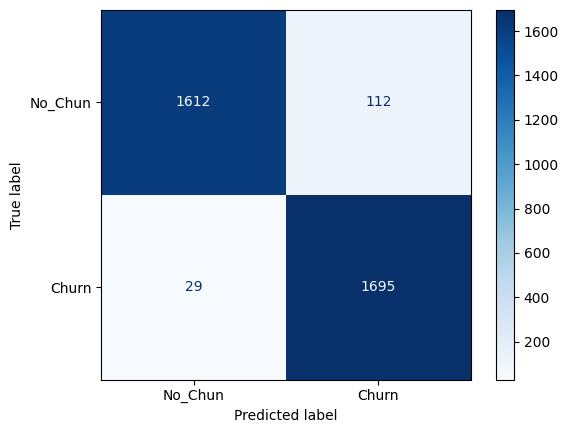

[[1612  112]
 [  29 1695]]


In [16]:
# Code task 15#
# Confusion Matrix
cm= confusion_matrix(y_test, y_pred)

# Code Task 2#
# Define the labels
labels = ['No_Chun', 'Churn']

# Code Task 3#
# Create the ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Code Task 4#
# Plot the confusion matrix
plt.figure(figsize=(2,2))
disp.plot(cmap=plt.cm.Blues)
plt.show()
print(confusion_matrix(y_test, y_pred))

##### 5.5.1-3.4 Classification Report

In [17]:
# Code task 16#
# Define the labels
labels = ['No_Churn', 'Churn']
# Classification Report 
print(classification_report(y_test, y_pred, target_names=labels))


              precision    recall  f1-score   support

    No_Churn       0.98      0.94      0.96      1724
       Churn       0.94      0.98      0.96      1724

    accuracy                           0.96      3448
   macro avg       0.96      0.96      0.96      3448
weighted avg       0.96      0.96      0.96      3448



### 5.5.2 Random Forest

In [18]:
# Code task 17#
# Instantiate the model
rf = RandomForestClassifier()

#### 5.5.2-1 Identifying the best parameters

##### 5.5.2-1.1 Using GridSearchCV

In [19]:
# Code task 18#
# Define the parameter grid
param_grid = {'n_estimators':[100,200,300], 
              'max_depth':[None, 10,20,30],
              'min_samples_split':[2, 5, 10, 15],
              'min_samples_leaf':[1, 2, 4, 6],
              'max_features': ['sqrt', 'log2',None],
              'bootstrap':[True, False]
             }
# Code task 19#
# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Code task 20#
# Fit the model
grid_search.fit(X_train, y_train)

# Code Task 4#
# Print the best parameters and best score
print('Best Parameters: ', grid_search.best_params_)
print('Best Score: ', grid_search.best_score_)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
Best Parameters:  {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Score:  0.9839036907624621


##### 5.5.2-1.2 Using RandomizedSearchCV

In [20]:
# Code task 21#
# Define the parameter distribution
param_dist ={
    'n_estimators': randint(100,500),
    'max_depth':[None, 10, 20, 30, 40],
    'min_samples_split': randint(2,20),
    'min_samples_leaf': randint(1,10),
    'max_features':[None,'sqrt','log2'],
    'bootstrap':[True, False]
}

# Code task 22#
# Instantiate the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions= param_dist,
                                   n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)

# Code task 23#
# Fit the model
random_search.fit(X_train, y_train)

# Code task 24#
# Print the best parameters and the best score
print('Best Parameters: ', random_search.best_params_)
print('Best Score: ', random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters:  {'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 200}
Best Score:  0.9816559215131125


##### The parameters obtained using GridSearchCV lead to a better score. We will retain them for the model

#### 5.5.2-2 The Model

In [21]:
# Code task 25#
# Instantiate the model
rf1 = RandomForestClassifier(n_estimators= 300 , max_depth= None, 
                             min_samples_split= 2 , min_samples_leaf= 1 , 
                             max_features='sqrt' , bootstrap=False)

# Code task 26#
# Fit the model
rf1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, n_estimators=300)

#### 5.5.2-3 Evaluate the Model

##### 5.5.2-3.1 Accuracy

In [22]:
# Code task 27#
# Use the score method to assess the accuracy of the model
accuracy_rf = rf1.score(X_test, y_test)
print(accuracy_rf)

0.9915893271461717


##### 5.5.2-3.2 Confusion Matrix

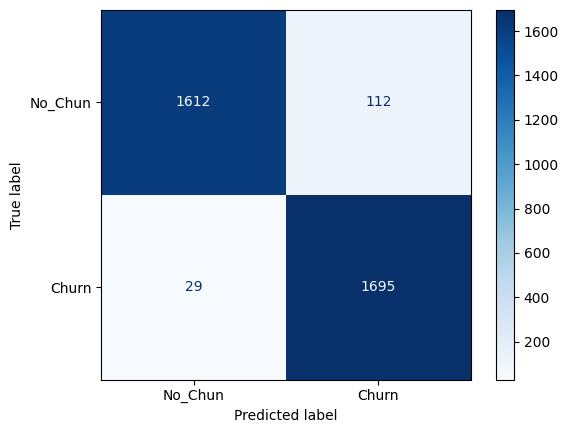

[[1612  112]
 [  29 1695]]


In [23]:
# Code task 28#
# Confusion Matrix
cm= confusion_matrix(y_test, y_pred)

# Code task 29#
# Define the labels
labels = ['No_Chun', 'Churn']

# Code task 30#
# Create the ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Code task 31#
# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.show()
print(confusion_matrix(y_test, y_pred))

##### 5.5.2-3.3 Classification Report

In [24]:
# Code task 32#
# Define the labels
labels = ['No_Churn', 'Churn']

# Code task 33#
# Classification Report 
print(classification_report(y_test, y_pred, target_names=labels))


              precision    recall  f1-score   support

    No_Churn       0.98      0.94      0.96      1724
       Churn       0.94      0.98      0.96      1724

    accuracy                           0.96      3448
   macro avg       0.96      0.96      0.96      3448
weighted avg       0.96      0.96      0.96      3448



##### 5.5.2-3.4 Cross-Validation

In [25]:
# Code task 34#
# Define the KFold Cross-Validation
kf = KFold(n_splits=6, shuffle=True, random_state=42)

# Code task 35#
#Cross-Validation
random_forest_train_results = cross_val_score(rf1, X_train, y_train, cv=kf, scoring='recall')
recall_train_rf = random_forest_train_results.mean()

# Code task 36#
# Predict on the test set
y_pred = rf1.predict(X_test)

# Code task 37#
# Evaluate the model on the test set
recall_test_rf = recall_score(y_test, y_pred)

# Code task 38#
# Print the performance
print(random_forest_train_results)
print(f'recall_train_rf = {recall_train_rf}')
print(f'recall_test_rf = {recall_test_rf}')


[0.99287622 0.99646331 0.99389712 0.99492386 0.9965368  0.99654577]
recall_train_rf = 0.9952071795179597
recall_test_rf = 0.9953596287703016


The test recall is slightly higher than the training recall, which is unusual but not alarming

### 5.5.3 Gradient Boosting

In [26]:
# Code task 39#
# Intantiate the model
gbc = GradientBoostingClassifier()

#### 5.5.3-1 Identifying the best parameters

##### 5.5.3-1.1 Using GridSearch

In [27]:
# Code task 40#
# Define the Grid parameters
param_grid = { 'n_estimators': [100, 200, 300], 
              'learning_rate': [0.01, 0.1, 0.2], 
              'max_depth': [3, 4, 5], 
              'min_samples_split': [2, 5, 10], 
              'min_samples_leaf': [1, 2, 4], 
              'max_features': ['sqrt', 'log2',None] 
             }

# Code task 41#
# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Code task 42#
# Fit the model
grid_search.fit(X_train, y_train)

# Code task 43#
# Print the best parameters and best score
print('Best Parameters: ', grid_search.best_params_)
print('Best Score: ', grid_search.best_score_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Parameters:  {'learning_rate': 0.2, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Best Score:  0.9822359206247284


##### 5.5.3-1.2 Using RandomizedSearchCV

In [28]:
# Code task 44#
# Define the parameter distribution
param_dist = { 'n_estimators': randint(100, 500), 
              'learning_rate': [0.01, 0.1, 0.2], 
              'max_depth': randint(3, 10), 
              'min_samples_split': randint(2, 20), 
              'min_samples_leaf': randint(1, 10), 
              'max_features': ['sqrt', 'log2',None] 
             }

# Code task 45#
# Instantiate the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=gbc, param_distributions= param_dist,
                                   n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)

# Code task 46#
# Fit the model
random_search.fit(X_train, y_train)

# Code task 47#
# Print the best parameters and the best score
print('Best Parameters: ', random_search.best_params_)
print('Best Score: ', random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters:  {'learning_rate': 0.1, 'max_depth': 9, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 18, 'n_estimators': 354}
Best Score:  0.9835409251967521


##### RandomizedSearch leads to the best score in the case of the Gradient Boosting Model. We'll use its parameters to build our model

### 5.5.3-2 The Model

In [29]:
# Code task 48#
# Instantiate the model
gbc1 = GradientBoostingClassifier(n_estimators =354, 
              learning_rate =0.1, 
              max_depth =9, 
              min_samples_split=18, 
              min_samples_leaf=8, 
              max_features= None)

# Code task 49#
# Fit the model
gbc1.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=9, min_samples_leaf=8,
                           min_samples_split=18, n_estimators=354)

### 5.5.3-3 Evaluate the model

#### 5.5.3-3.1 Accuracy

In [30]:
# Code task 50#
# Use the score method to calculate the accuracy of the model
accuracy_gbc = gbc1.score(X_test, y_test)
print(accuracy_gbc)

0.9912993039443155


#### 5.5.3-3.2 Confusion Matrix

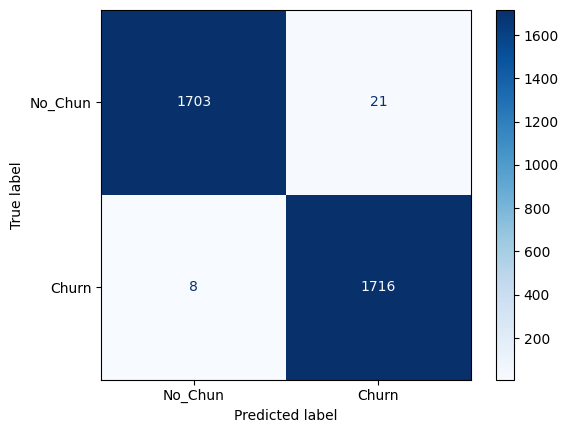

[[1703   21]
 [   8 1716]]


In [31]:
# Code task 51#
# Confusion Matrix
cm= confusion_matrix(y_test, y_pred)

# Code task 52#
# Define the labels
labels = ['No_Chun', 'Churn']

# Code task 53#
# Create the ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Code task 54#
# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.show()
print(confusion_matrix(y_test, y_pred))

#### 5.5.3-3.3 Classification Report

In [32]:
# Code task 55#
# Define the labels
labels = ['No_Churn', 'Churn']

# Code task 56#
# Classification Report 
print(classification_report(y_test, y_pred, target_names=labels))


              precision    recall  f1-score   support

    No_Churn       1.00      0.99      0.99      1724
       Churn       0.99      1.00      0.99      1724

    accuracy                           0.99      3448
   macro avg       0.99      0.99      0.99      3448
weighted avg       0.99      0.99      0.99      3448



#### 5.5.3-3.4 Cross-Validation

In [33]:
# Code task 57#
# Define the KFold Cross-Validation
kf = KFold(n_splits=6, shuffle=True, random_state=42)

# Code task 58#
#Cross-Validation
gradient_boostin_train_results = cross_val_score(gbc1, X_train, y_train, cv=kf, scoring='recall')
recall_train_gbc = gradient_boostin_train_results.mean()

# Code task 59#
# Predict on the test set
y_pred = gbc1.predict(X_test)

# Code task 60#
# Evaluate the model on the test set
recall_test_gbc = recall_score(y_test, y_pred)

# Code task 61#
print(gradient_boostin_train_results)
print(f'recall_train_gb= {recall_train_gbc}')
print(f'recall_test_gb = {recall_test_gbc}')

[0.9937667  0.99027409 0.99476896 0.99238579 0.99480519 0.99309154]
recall_train_gb= 0.9931820452204242
recall_test_gb = 0.9959396751740139


## 5.6 Comparison of the models

In [34]:
# Code task 62#
# Create lists of the performance of the three models
models = ['KNN', 'Random Forest', 'Gradient Boosting']
score_test= [recall_test_knn, recall_test_rf, recall_test_gbc]
score_train =[recall_train_knn, recall_train_rf, recall_train_gbc]
Accuracy_score = [accuracy_knn, accuracy_rf, accuracy_gbc]

# Code task 63#
# Create a DataFrame of the performance of the three models
score_tab = pd.DataFrame(list(zip(models, score_train, score_test,Accuracy_score)), columns =['Model','Recall_train','Recall_test','Accuracy'])

# Code task 64#
# Display the DataFrame
score_tab

,Model,Recall_train,Recall_test,Accuracy
0,KNN,0.979384,0.983179,0.959107
1,Random Forest,0.995207,0.995360,0.991589
2,Gradient Boosting,0.993182,0.995940,0.991299


## 5.7 Conclusion

The Gradient Boosting model has the highest recall test and accuracy score close to the Random Forest model. For this reason we keep it as model to identify customers likely to churn.

The model is exceptional performance, with:
Accuracy: 99.12%
F1-Score: 0.99 for both classes.

The model is robust, balanced, and effective, with only a minor improvement needed in recall for the Churn class. 


## END